<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #22c1c3;">DL Project |</span> <span style="color: #08529C;">Predicting Rare Species from Images using Deep Learning</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Diogo Duarte, 20240525</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Maria Cruz, 20230760</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

## **📚 Libraries Import**

In [2]:
# !pip install visualkeras

In [1]:
# System imports
import os
import sys
import time
import datetime
from tqdm import tqdm
from typing_extensions import Self, Any      # For Python 3.10
# from typing import Self, Any               # For Python >3.11

from pathlib import Path

# Data manipulation imports
import numpy as np
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning imports
import tensorflow as tf
from keras.ops import add
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Lambda, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers                                                                           # For L2 regularization
import visualkeras

# Evaluation imports
from keras.metrics import CategoricalAccuracy, AUC, F1Score, Precision, Recall

# Other imports
from itertools import product

# Set the style of the visualization
pd.set_option('future.no_silent_downcasting', True)   # use int instead of float in DataFrame
pd.set_option("display.max_columns", None)            # display all columns

# Disable warnings (FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set random seed for reproducibility
np.random.seed(2025)

2025-04-13 16:08:30.614101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744556910.812029   16460 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744556910.872394   16460 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744556911.286298   16460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744556911.286337   16460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744556911.286339   16460 computation_placer.cc:177] computation placer alr

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())                                # (if error in Google Colab: Make sure your Hardware accelerator is set to GPU. 
                                                                                    # Runtime > Change runtime type > Hardware Accelerator)

TensorFlow Version: 2.19.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1744556918.559210   16460 gpu_device.cc:2019] Created device /device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Get build information from TensorFlow
build_info = tf.sysconfig.get_build_info()

print("TensorFlow version:", tf.__version__)
print("Python version:", sys.version)
print("CUDA version:", build_info.get("cuda_version", "Not available"))
print("cuDNN version:", build_info.get("cudnn_version", "Not available"))

TensorFlow version: 2.19.0
Python version: 3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]
CUDA version: 12.5.1
cuDNN version: 9


In [4]:
# Extra: https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
# If you’re using a GPU, TensorFlow might pre-allocate GPU memory, leaving less for CPU operations. 
# Enabling memory growth lets the GPU allocate only what’s needed.
if tf.test.is_built_with_cuda():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_memory_growth(gpu, False)

In [5]:
# Import custom module for importing data, visualization, and utilities
import utilities

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

## **🧮 Import Databases**

In [ ]:
# # Run in Google Collab to download the dataset already splitted
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drivez
# # Download the file from Google Drive using wget
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1dmr2cGxgM-kp1aXlmd9cQzVCkcl4JTFo&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1dmr2cGxgM-kp1aXlmd9cQzVCkcl4JTFo&export=download&confirm={confirm_token}" \
#   -O /content/RareSpecies_Split.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

# # List files in the /content directory to verify the download
# !ls -lh /content/

# # Unzip the downloaded file
# !unzip /content/RareSpecies_Split.zip -d /content/

# # List the unzipped files to verify
# !ls -lh /content/

In [7]:
# Define the path to the data
train_dir = Path("data/RareSpecies_Split/train")
val_dir = Path("data/RareSpecies_Split/val")
test_dir = Path("data/RareSpecies_Split/test")

# For Google Collab
# train_dir = Path("/content/RareSpecies_Split/train")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

In [8]:
# Image Generators 
n_classes = 202                                     # Number of classes (we already know this based on previous notebook)
image_size = (224, 224)                             # Image size (224x224)
img_height, img_width = image_size                  # Image dimensions
batch_size = 64                                     # Batch size
input_shape = (img_height, img_width, 3)            # Input shape of the model
value_range = (0.0, 1.0)                            # Range of pixel values

In [9]:
# Get class names from directory
class_names = sorted(os.listdir(train_dir))
class_indices = {name: i for i, name in enumerate(class_names)}

# Import the image dataset from the directory
from utilities import load_images_from_directory
train_datagen, val_datagen, test_datagen = load_images_from_directory(train_dir, val_dir, test_dir,
                                                                      labels='inferred', label_mode='categorical',
                                                                      class_names=class_names, color_mode='rgb',
                                                                      batch_size=batch_size, image_size=image_size, seed=2025, 
                                                                      interpolation='bilinear', crop_to_aspect_ratio=False, pad_to_aspect_ratio=False)

print(f"\nLoaded: Train ({train_datagen.cardinality().numpy() * batch_size}), "
        f"Val ({val_datagen.cardinality().numpy() * batch_size}), "
        f"Test ({test_datagen.cardinality().numpy() * batch_size})")

Found 9586 files belonging to 202 classes.


I0000 00:00:1744556920.210259   16460 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1198 files belonging to 202 classes.
Found 1199 files belonging to 202 classes.

Loaded: Train (9600), Val (1216), Test (1216)


In [10]:
# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

Train batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 16:08:44.055793: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Val batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 16:08:44.547556: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 16:08:45.038699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67160576 bytes after encountering the first element of size 67160576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


# <a class='anchor' id='3'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>3 | Modeling - Baseline Model</b></h1></center>
</div>

<br><br>

# **💡 Modeling**

In [ ]:
# Baseline Model
class RareSpeciesCNN(Model):
    """Custom CNN for rare species classification.
    
    Architecture: Simple CNN 
    Why: Small model to establish baseline, avoiding overfitting on 202 classes.
    Alternatives: Deeper CNNs (e.g., ResNet) or transfer learning (e.g., EfficientNet).
    Allows selection of preprocessing steps like grayscale, contrast, and saturation adjustment.
    """
    def __init__(self, n_classes=202,                                   # Number of output classes
                 apply_grayscale=False,                                 # If True, convert images to grayscale
                 apply_contrast=False, contrast_factor=1.5,             # 1.5 = increase contrast
                 apply_saturation=False, saturation_factor=1.5):        # 1.5 = increase saturation
        """Initializes the model.
        
        Args:
            n_classes (int): Number of output classes.
            apply_grayscale (bool): If True, convert images to grayscale first.
            apply_contrast (bool): If True, adjust image contrast.
            contrast_factor (float): Factor for contrast adjustment.
            apply_saturation (bool): If True, adjust image saturation.
            saturation_factor (float): Factor for saturation adjustment.
        """
        super().__init__() # Call the parent class constructor
        
        # Store preprocessing flags and factors
        self.apply_grayscale = apply_grayscale
        self.apply_contrast = apply_contrast
        self.apply_saturation = apply_saturation
        
        # --- Preprocessing Layers ---        
        # Rescaling layer (always applied)
        self.rescale_layer = Rescaling(scale= 1 / 255.0, name="Rescale_Layer")    # Rescales pixel values to [0, 1]
        
        # Conditionally define Lambda layer for contrast adjustment
        if self.apply_contrast:
            # Define Lambda layer for contrast adjustment
            # Source: https://keras.io/api/layers/core_layers/lambda/
            #         https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
            #         contrast_factor > 1 increases contrast, < 1 decreases contrast
            self.contrast_layer = Lambda(
                lambda x: tf.image.adjust_contrast(x, contrast_factor=contrast_factor),
                name='Adjust_Contrast'
            )
        
        # Conditionally define Lambda layer for saturation adjustment
        if self.apply_saturation:
            # Define Lambda layer for saturation adjustment
            # Source: https://www.tensorflow.org/api_docs/python/tf/image/adjust_saturation
            #         saturation_factor > 1 increases saturation, < 1 decreases saturation
            self.saturation_layer = Lambda(
                lambda x: tf.image.adjust_saturation(x, saturation_factor=saturation_factor),
                name='Adjust_Saturation'
            )
            
        # Conditionally define Lambda layer for grayscale conversion
        if self.apply_grayscale:
            # Define Lambda layer for grayscale conversion
            # Source: https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale
            self.grayscale_layer = Lambda(
                lambda x: tf.image.rgb_to_grayscale(x), 
                name='RGB_to_Grayscale'
            )
            # IMPORTANT: Add a Conv2D layer immediately after grayscale to ensure 
            #            the number of channels is compatible with subsequent layers 
            #            if they expect 3 channels. Here, we'll keep it 1 channel and adjust conv1.
            # Alternatively, convert grayscale back to 3 identical channels:
            # self.grayscale_to_rgb_layer = Lambda(
            #     lambda x: tf.image.grayscale_to_rgb(x),
            #     name='Grayscale_to_RGB'
            # )
            
            
        # --- Convolutional Layers ---
        # Adjust the first Conv layer's input channels if grayscale is applied and not converted back to RGB
        # If grayscale IS applied, the input to conv1 will have 1 channel.
        # If grayscale IS NOT applied, the input will have 3 channels (after rescaling).
        # We will handle this by checking the shape dynamically or assuming subsequent layers can handle 1 channel if needed.
        # For simplicity here, let's assume conv1 works with either 1 or 3 channels.
        # If grayscale is applied, the input depth is 1, otherwise 3.
        # A more robust way might involve explicitly setting input_shape or checking channels.
        # Let's define conv1 to work even if input is grayscale (1 channel)
        
        # Block 1
        # Source: https://stackoverflow.com/questions/60157742/convolutional-neural-network-cnn-input-shape/61075207#61075207 (Explain Conv2D)
        self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', name="Conv_Block1_Conv")
        self.bn1 = BatchNormalization(name="Conv_Block1_BN")
        self.act1 = Activation('relu', name="Conv_Block1_Act")
        self.pool1 = MaxPooling2D(pool_size=(2, 2), name="Conv_Block1_Pool") # Output: 112x112x32

        # Block 2
        self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name="Conv_Block2_Conv")
        self.bn2 = BatchNormalization(name="Conv_Block2_BN")
        self.act2 = Activation('relu', name="Conv_Block2_Act")
        self.pool2 = MaxPooling2D(pool_size=(2, 2), name="Conv_Block2_Pool") # Output: 56x56x64

        # Block 3
        self.conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', name="Conv_Block3_Conv")
        self.bn3 = BatchNormalization(name="Conv_Block3_BN")
        self.act3 = Activation('relu', name="Conv_Block3_Act")
        self.pool3 = MaxPooling2D(pool_size=(2, 2), name="Conv_Block3_Pool") # Output: 28x28x128

        # --- Classification Head ---
        self.global_avg_pool = GlobalAveragePooling2D(name="Global_Average_Pooling")
        self.flatten = Flatten(name="Flatten_Layer")
        self.dense1 = Dense(128, name="Dense_Layer1")                                     # Smaller intermediate dense layer
        self.bn_dense1 = BatchNormalization(name="Dense_Layer1_BN")
        self.act_dense1 = Activation('relu', name="Dense_Layer1_Act")
        self.dropout = Dropout(0.7, name="Dropout_Layer")
        self.dense_output = Dense(n_classes, activation='softmax', name="Output_Layer")

    def call(self: Self, inputs: Any, training:bool=False) -> Any:
        """Defines the forward pass of the model.
        
        Args:
            inputs: Input tensor (batch of images).
            training (bool): Indicates if the model is in training mode (for Dropout).
            
        Returns:
            Output tensor (probabilities for each class).
        """
        # Apply mandatory rescaling
        x = self.rescale_layer(inputs)
        
        # Apply conditional preprocessing layers
        if self.apply_contrast:
            x = self.contrast_layer(x)
        if self.apply_saturation:
            x = self.saturation_layer(x)
        if self.apply_grayscale:
            x = self.grayscale_layer(x)
            # If subsequent layers strictly require 3 channels, uncomment this:
            # x = self.grayscale_to_rgb_layer(x) 
            # Note: If grayscale is applied, conv1 will process a 1-channel input unless converted back.
        
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.pool3(x)

        # Classification Head
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn_dense1(x, training=training)
        x = self.act_dense1(x)
        x = self.dropout(x, training=training)
        outputs = self.dense_output(x)

        return outputs

# Example Instantiation and Summary
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=False,
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

Model: "rare_species_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescale_Layer (Rescaling)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block1_Conv (Conv2D)       │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block1_BN                  │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block1_Act (Activation)    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block1_Pool (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block2_Conv (Conv2D)       │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block2_BN                  │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block2_Act (Activation)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block2_Pool (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block3_Conv (Conv2D)       │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block3_BN                  │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block3_Act (Activation)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Block3_Pool (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global_Average_Pooling          │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer1 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer1_BN                 │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer1_Act (Activation)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 202)            │        26,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,226 (536.04 KB)

 Trainable params: 136,522 (533.29 KB)

 Non-trainable params: 704 (2.75 KB)

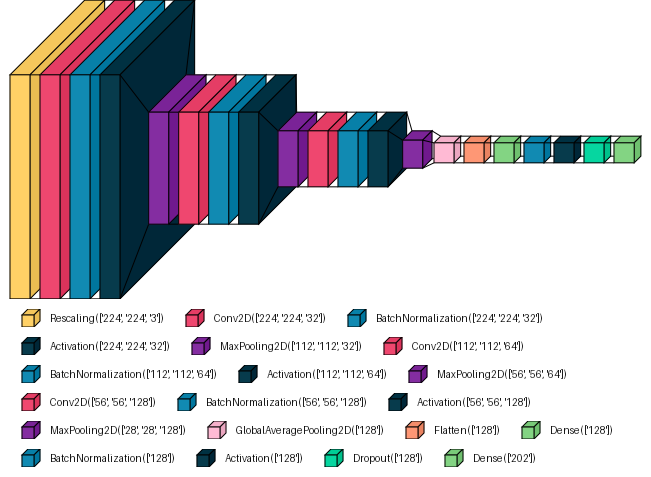

In [12]:
# Visualize the model architecture
# Source: https://www.kaggle.com/code/devsubhash/visualize-deep-learning-models-using-visualkeras
visualkeras.layered_view(model, 
                         legend=True, 
                         show_dimension=True,
                         scale_xy=1,                                        # Adjust the scale of the image
                        #  scale_z=1,
                         # to_file='./BaselineModel_Architecture.png',
).show()

In [65]:
# Compile model
# optimizer = SGD(learning_rate=0.1, weight_decay=0.01, name="Optimizer")                                         # SGD with decay for stability
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                        # Adam for faster convergence

loss = CategoricalCrossentropy(name="Loss")                                                                       # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), 
           Precision(name="precision"),
           Recall(name="recall"), 
           F1Score(average="macro", name="f1_score"),
           AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [66]:
# Create a directory for saving the model and logs
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}"                                                                             # Model name 
print(f"\n\033[1mModel name:\033[0m {model_name}")


Model name: RareSpeciesCNN_20250412


In [67]:
# Callbacks
# Create a directory for saving the model and logs
os.makedirs("./ModelCallbacks", exist_ok=True)      # Create directory if it doesn't exist
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}"                                                                             # Model name 
callbacks = [
    ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0),       # Save best model
    CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"),                                                                      # Log training metrics
    LearningRateScheduler(lambda epoch, lr: lr * 0.95),                                                                           # Exponential decay for learning rate
    EarlyStopping(monitor='val_loss', patience=3, verbose=1)                                                                      # Stop training when the validation loss stops improving
]

---

### **Original Dataset | Grayscale=F | Contrast=F | Saturation=F**

In [ ]:
# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)

print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

##### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics

os.makedirs("./ModelsEvaluation", exist_ok=True)                                              # Create directory if it doesn't exist
plot_metrics(history, file_path=f"./ModelsEvaluation/2_Training_Validation_Metrics_{datetime.datetime.now().strftime('%Y%m%d')}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

In [ ]:
# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model",
    variation="Original | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001",           # Dataset | Grayscale | Contrast | Saturation | Optimizer=Learning Rate
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"      # Save the results to a CSV file
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Original Dataset | Grayscale=T | Contrast=F | Saturation=F**

In [ ]:
# Model - Original Dataset | Grayscale=T | Contrast=F | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=True, 
    apply_contrast=False,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
# optimizer = SGD(learning_rate=0.1, weight_decay=0.01, name="Optimizer")                                         # SGD with decay for stability
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                        # Adam for faster convergence

loss = CategoricalCrossentropy(name="Loss")                                                                       # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_OriginalGrayscale" # Model name 
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

In [ ]:
# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

##### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Original | Grayscale=T | Contrast=F | Saturation=F | Adam=0.001",   # Dataset | Grayscale | Contrast | Saturation | Optimizer=Learning Rate
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Original Dataset | Grayscale=F | Contrast=T | Saturation=F**

In [ ]:
# Model - Original Dataset | Grayscale=F | Contrast=T | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=True,                         
    apply_saturation=False
)
# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
# optimizer = SGD(learning_rate=0.1, weight_decay=0.01, name="Optimizer")                                         # SGD with decay for stability
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                        # Adam for faster convergence
loss = CategoricalCrossentropy(name="Loss")                                                                       # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_OriginalContrast" # Model name
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Original | Grayscale=F | Contrast=T | Saturation=F | Adam=0.001",   # Dataset | Grayscale | Contrast | Saturation | Optimizer=Learning Rate
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Original Dataset | Grayscale=F | Contrast=F | Saturation=T**

In [ ]:
# Model - Original Dataset | Grayscale=F | Contrast=F | Saturation=T
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=True
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
# optimizer = SGD(learning_rate=0.1, weight_decay=0.01, name="Optimizer")                                         # SGD with decay for stability
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                        # Adam for faster convergence
loss = CategoricalCrossentropy(name="Loss")                                                                       # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_OriginalSaturation" # Model name
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Original | Grayscale=F | Contrast=F | Saturation=T | Adam=0.001",   # Dataset | Grayscale | Contrast | Saturation | Optimizer=Learning Rate
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

--- 

# **🖌️ SMOTE (Dataset Augmentation)**

In [ ]:
# Load train data with Data Augmentation (SMOTE)
from utilities import load_images_from_directory

train_DataAugmentationSMOTE_dir = Path("data/RareSpecies_Split/train_DataAugmentationSMOTE")
val_dir = Path("data/RareSpecies_Split/val")
test_dir = Path("data/RareSpecies_Split/test")

# train_DataAugmentationSMOTE_dir = Path("/content/RareSpecies_Split/train_DataAugmentationSMOTE")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

class_names = sorted(os.listdir(train_DataAugmentationSMOTE_dir))
class_indices = {name: i for i, name in enumerate(class_names)}

# Import the image dataset from the directory
train_DataAugmentationSMOTE_datagen, val_datagen, test_datagen = load_images_from_directory(train_DataAugmentationSMOTE_dir, val_dir, test_dir,
                                                                      labels='inferred', label_mode='categorical',
                                                                      class_names=class_names, color_mode='rgb',
                                                                      batch_size=batch_size, image_size=image_size, seed=2025, 
                                                                      interpolation='bilinear', crop_to_aspect_ratio=False, pad_to_aspect_ratio=False)

# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_DataAugmentationSMOTE_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

In [ ]:
# Check class distribution
train_class_counts = {class_name: len(list((train_DataAugmentationSMOTE_dir / class_name).glob('*')))
                      for class_name in list(class_names)}
train_class_distribution = pd.DataFrame({
    'n': train_class_counts.values(),
    '%': [count / sum(train_class_counts.values()) * 100 for count in train_class_counts.values()],
})
train_class_distribution

## **SMOTE Data Augmentation | Grayscale=F | Contrast=F | Saturation=F**


In [ ]:
# Model - SMOTE Data Augmentation | Grayscale=F | Contrast=F | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_SMOTE"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_DataAugmentationSMOTE_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="SMOTE | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time, 
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **SMOTE Data Augmentation | Grayscale=T | Contrast=F | Saturation=F**


In [ ]:
# Model - SMOTE Data Augmentation | Grayscale=T | Contrast=F | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=True, 
    apply_contrast=False,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_SMOTEGrayscale"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_DataAugmentationSMOTE_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="SMOTE | Grayscale=T | Contrast=F | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **SMOTE Data Augmentation | Grayscale=F | Contrast=T | Saturation=F**


In [ ]:
# Model - SMOTE Data Augmentation | Grayscale=F | Contrast=T | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=True,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_SMOTEContrast"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_DataAugmentationSMOTE_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="SMOTE | Grayscale=F | Contrast=T | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **SMOTE Data Augmentation | Grayscale=F | Contrast=F | Saturation=T**


In [ ]:
# Model - SMOTE Data Augmentation | Grayscale=F | Contrast=F | Saturation=T
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=True
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_SMOTESaturation"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_DataAugmentationSMOTE_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="SMOTE | Grayscale=F | Contrast=F | Saturation=T | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

# **🏋️ Weights**


In [ ]:
# Count Samples in Each Class in the Original Training Set
original_class_counts = {}
total_samples = 0
for class_name in class_names:
    class_path = train_dir / class_name
    if class_path.is_dir():
        count = len(list(class_path.glob('*'))) # Count image files
        original_class_counts[class_name] = count
        total_samples += count
    else:
        print(f"Warning: Expected directory not found: {class_path}")

# Calculate Class Weights
# Formula: weight_for_class_i = (total_samples / (num_classes * samples_in_class_i))  -> This gives higher weight to smaller classes.
class_weights = {}
for class_name, count in original_class_counts.items():
    if count == 0:
        print(f"Warning: Class '{class_name}' has 0 samples. Assigning weight 0.")
        weight = 0.0
    else:
        weight = (total_samples) / (len(class_names) * count)

    # Get the index for this class name
    class_index = class_indices[class_name]
    class_weights[class_index] = weight

## **Weights | Grayscale=F | Contrast=F | Saturation=F**


In [ ]:
# Model - Weights | Grayscale=F | Contrast=F | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_Weights"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1, 
                    class_weight=class_weights) # Pass class weights to the fit method
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Weights | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Weights | Grayscale=T | Contrast=F | Saturation=F**


In [ ]:
# Model - Weights | Grayscale=T | Contrast=F | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=True, 
    apply_contrast=False,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_WeightsGrayscale"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1, class_weight=class_weights)
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Weights | Grayscale=T | Contrast=F | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Weights | Grayscale=F | Contrast=T | Saturation=F**


In [ ]:
# Model - Weights | Grayscale=F | Contrast=T | Saturation=F
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=True,                         
    apply_saturation=False
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_WeightsContrast"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1, 
                    class_weight=class_weights)    # Pass class weights to the fit method
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Weights | Grayscale=F | Contrast=T | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

## **Weights | Grayscale=F | Contrast=F | Saturation=T**


In [ ]:
# Model - Weights | Grayscale=F | Contrast=F | Saturation=T
model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=True
)

# Build the model by providing an input shape
inputs = Input(shape=(img_width, img_height, 3))        # Input shape
_ = model.call(inputs)                                  # Call the model to build it
model.summary()                                         # Print the model summary

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")
loss = CategoricalCrossentropy(name="Loss")
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Callbacks
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}_WeightsSaturation"
callbacks = [ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0), CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"), LearningRateScheduler(lambda epoch, lr: lr * 0.95), EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size=batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1, 
                    class_weight=class_weights)     # Pass class weights to the fit method
train_time = round(time.time() - start_time, 2)
print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

#### **🧪 Model Selection & 📏 Model Evaluation**

In [ ]:
# Evaluate model
from utilities import plot_metrics
plot_metrics(history, file_path=f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.png")

In [ ]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model", variation="Weights | Grayscale=F | Contrast=F | Saturation=T | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

---

# **🥇 Best Model - Predictions Analysis**

In [13]:
# Import SMOTE training data
train_DataAugmentationSMOTE_dir = Path("data/RareSpecies_Split/train_DataAugmentationSMOTE")
val_dir = Path("data/RareSpecies_Split/val")
test_dir = Path("data/RareSpecies_Split/test")

# train_DataAugmentationSMOTE_dir = Path("/content/RareSpecies_Split/train_DataAugmentationSMOTE")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

# Import the image dataset from the directory
train_DataAugmentationSMOTE_datagen, val_datagen, test_datagen = load_images_from_directory(train_DataAugmentationSMOTE_dir, val_dir, test_dir,
                                                                      labels='inferred', label_mode='categorical',
                                                                      class_names=class_names, color_mode='rgb',
                                                                      batch_size=batch_size, image_size=image_size, seed=2025, 
                                                                      interpolation='bilinear', crop_to_aspect_ratio=False, pad_to_aspect_ratio=False)
# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_DataAugmentationSMOTE_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

Found 48480 files belonging to 202 classes.
Found 1198 files belonging to 202 classes.
Found 1199 files belonging to 202 classes.
Train batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 16:08:56.199954: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67108864 bytes after encountering the first element of size 67108864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-04-13 16:08:56.200250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67108864 bytes after encountering the first element of size 67108864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-04-13 16:08:56.331245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 16:08:57.227139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67160576 bytes after encountering the fir

Val batch shape: (64, 224, 224, 3) (64, 202)
Test batch shape: (64, 224, 224, 3) (64, 202)


In [15]:
# Build the model by providing an input shape to load the best weights
best_model = RareSpeciesCNN(
    n_classes=n_classes, 
    apply_grayscale=False, 
    apply_contrast=False,                         
    apply_saturation=False
)

inputs = Input(shape=(img_width, img_height, 3))   # Input shape
best_model.build(inputs.shape)                          # Build the model

# Load the best model weights (since we saved it during training - Callback > ModelCheckpoint > .keras)
# Source: https://stackoverflow.com/questions/66138748/tensorflow-2-3-load-model-from-modelcheckpoint-callback-with-both-custom-layers
best_model.load_weights(f"./Collab/3_BaselineModel_Collab_CallbacksEvaluation_André_12.04.2025/content/ModelCallbacks/checkpoint_RareSpeciesCNN_20250413_SMOTE.keras")

optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                         # Adam for faster convergence
loss = CategoricalCrossentropy(name="Loss")                                                                        # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), F1Score(average="macro", name="f1_score"), AUC(name="auc")]
best_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Evaluate on validation and test sets
train_results = best_model.evaluate(train_DataAugmentationSMOTE_datagen, batch_size=batch_size, return_dict=True, verbose=1)
val_results = best_model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = best_model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

In [ ]:
# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Best Model", variation="SMOTE | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001",
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=None,
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

In [ ]:
# Plot the metrics
from utilities import plot_metrics

# Load the history from the CSV file
history_csv_path = f"./Collab/3_BaselineModel_Collab_CallbacksEvaluation_André_12.04.2025/content/ModelCallbacks/metrics_RareSpeciesCNN_20250413_SMOTE.csv"
history = pd.read_csv(history_csv_path)
history.set_index('epoch', inplace=True)
plot_metrics(history)

In [ ]:
from utilities import plot_confusion_matrix

# Plot confusion matrix for test set
plot_confusion_matrix(
    y_true=test_datagen.classes,
    y_pred=model.predict(test_datagen, batch_size=batch_size),
    title="Confusion Matrix | Best Baseline Model",
    # file_path="./ModelsEvaluation/3_TestConfusionMatrix_BestBaselineModel.png",
)

In [ ]:
# Plot 5 right and 5 wrong predictions
from utilities import plot_predictions
plot_predictions(
    model=model,
    data=test_datagen,
    n_samples=5,
    file_path=None
)

---

#### **🟨 Google Collab**

In [ ]:
# Save Google Collab Workspace
# Source: https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace
# !zip -r /content/ModelCallbacks.zip /content/ModelCallbacks

In [ ]:
# !zip -r /content/ModelsEvaluation.zip /content/ModelsEvaluation

In [ ]:
# from google.colab import files
# files.download("/content/ModelCallbacks.zip")

In [ ]:
# files.download("/content/ModelsEvaluation.zip")

---